## Часть 1
Напишите скрипт, который скачивает все данные с выборов губернатора СПб 2019г для всех избирательных участков. 

Входная точка [по ссылке](http://notelections.online/region/region/st-petersburg?action=show&root=1&tvd=27820001217417&vrn=27820001217413&region=78&global=&sub_region=78&prver=0&pronetvd=null&vibid=27820001217417&type=222). Затем нужно перейти на сайты территориальных избирательных комиссий. Результаты нужно сохранить в  `cvs`-файл, `sqlite` базе данных или `parquet`-файле. В итоге должна получиться таблица с полями:
- название ТИК (территориальная избирательная комиссия, некоторое объединение избирательных участков на определенной территории)
- номер УИК (избирательный участок)
- 14 стандартных полей из итогового протокола

Скрипт должен быть в отдельном `*.py` файле или в отдельном `jupyter`-ноутбуке. 

### Часть 2
Используя скаченные данные и `Pandas` (или `PySpark`) посчитайте:
- явку (%) по всем ТИК, результат отсортировать по убыванию
- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)
- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна
- посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)
- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат
- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

In [37]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [38]:
df = pd.read_csv("../data/task5_data.csv",index_col=[0]).T


df

,Номер ТИК,Номер УИК,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна
0_x,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,575,0,0,110,345,120
1_x,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,425,0,0,53,326,46
2_x,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,583,0,0,155,332,96
3_x,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,309,0,0,67,171,71
4_x,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,485,0,0,137,266,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,Территориальная избирательная комиссия №30,УИК №2350,284,300,166,53,81,53,166,0,219,0,0,21,184,14
46_y.12,Территориальная избирательная комиссия №30,УИК №2351,132,150,86,27,37,27,86,2,111,0,0,7,91,13
47,Территориальная избирательная комиссия №30,УИК №2352,320,350,217,23,110,23,217,4,236,0,0,20,193,23
48_y.11,Территориальная избирательная комиссия №30,УИК №2355,485,500,335,12,153,12,335,2,345,0,0,23,290,32


- явку (%) по всем ТИК, результат отсортировать по убыванию

In [39]:
df["Всего бюллетеней"]=df["Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования"].astype(int) + df["Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования"].astype(int)
df["Явка, %"] = df["Всего бюллетеней"].astype(int) / df["Число избирателей, внесенных в список избирателей на момент окончания голосования"].astype(int) * 100

df.sort_values("Явка, %", ascending=False, inplace=False)


,Номер ТИК,Номер УИК,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,Число действительных избирательных бюллетеней,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Всего бюллетеней,"Явка, %"
19_x.7,Территориальная избирательная комиссия №15,УИК №2293,203,300,151,52,97,52,151,10,193,0,0,20,142,31,203,100.000000
76_y.2,Территориальная избирательная комиссия №22,УИК №408,201,500,120,81,299,81,120,9,192,0,0,17,140,35,201,100.000000
65_y.2,Территориальная избирательная комиссия №17,УИК №2284,235,500,235,0,265,0,235,11,224,0,0,17,165,42,235,100.000000
69_x.4,Территориальная избирательная комиссия №21,УИК №2343,76,200,63,13,124,13,63,1,75,0,0,8,64,3,76,100.000000
75,Территориальная избирательная комиссия №29,УИК №2178,126,500,126,0,374,0,126,0,126,0,0,12,114,0,126,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2_x.2,Территориальная избирательная комиссия №5,УИК №1424,1814,1700,320,1,1379,1,320,6,315,0,0,45,225,45,321,17.695700
79_x.1,Территориальная избирательная комиссия №6,УИК №1139,1848,1500,317,3,1180,3,317,10,310,0,0,53,186,71,320,17.316017
67_y.6,Территориальная избирательная комиссия №26,УИК №1215,1959,2000,331,8,1661,8,331,9,330,0,0,62,194,74,339,17.304747
4_y.4,Территориальная избирательная комиссия №10,УИК №203,859,800,143,1,656,1,143,7,137,0,0,37,71,29,144,16.763679


- выберите произвольного кандидата и найдите тот избиратльный участок, на котором он получил наибольший результат  (%, учитывать участки на которых проголосовало больше 100 человек)

In [40]:
candidates = ["Амосов Михаил Иванович","Беглов Александр Дмитриевич", "Тихонова Надежда Геннадьевна"]

In [41]:
for candidate in candidates:
    df[f"{candidate}, %"] = 0
    df.loc[df["Всего бюллетеней"].astype(int) >= 100, f"{candidate}, %"] = df[f"{candidate}"].astype(int) / df["Всего бюллетеней"].astype(int) * 100
df

,Номер ТИК,Номер УИК,"Число избирателей, внесенных в список избирателей на момент окончания голосования","Число избирательных бюллетеней, полученных участковой избирательной комиссией","Число избирательных бюллетеней, выданных избирателям в помещении для голосования в день голосования","Число избирательных бюллетеней, выданных избирателям, проголосовавшим вне помещения для голосования",Число погашенных избирательных бюллетеней,"Число избирательных бюллетеней, содержащихся в переносных ящиках для голосования","Число избирательных бюллетеней, содержащихся в стационарных ящиках для голосования",Число недействительных избирательных бюллетеней,...,Число утраченных избирательных бюллетеней,"Число избирательных бюллетеней, не учтенных при получении",Амосов Михаил Иванович,Беглов Александр Дмитриевич,Тихонова Надежда Геннадьевна,Всего бюллетеней,"Явка, %","Амосов Михаил Иванович, %","Беглов Александр Дмитриевич, %","Тихонова Надежда Геннадьевна, %"
0_x,Территориальная избирательная комиссия №1,УИК №1,1803,1200,587,11,602,11,587,23,...,0,0,110,345,120,598,33.166944,18.394649,57.692308,20.066890
1_x,Территориальная избирательная комиссия №1,УИК №2,1466,1100,433,14,653,14,430,19,...,0,0,53,326,46,444,30.286494,11.936937,73.423423,10.360360
2_x,Территориальная избирательная комиссия №1,УИК №3,2092,1600,576,22,1002,22,576,15,...,0,0,155,332,96,598,28.585086,25.919732,55.518395,16.053512
3_x,Территориальная избирательная комиссия №1,УИК №4,1056,1000,318,4,678,4,318,13,...,0,0,67,171,71,322,30.492424,20.807453,53.105590,22.049689
4_x,Территориальная избирательная комиссия №1,УИК №5,1827,1400,495,8,897,8,493,16,...,0,0,137,266,82,501,27.422003,27.345309,53.093812,16.367265
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,Территориальная избирательная комиссия №30,УИК №2350,284,300,166,53,81,53,166,0,...,0,0,21,184,14,219,77.112676,9.589041,84.018265,6.392694
46_y.12,Территориальная избирательная комиссия №30,УИК №2351,132,150,86,27,37,27,86,2,...,0,0,7,91,13,113,85.606061,6.194690,80.530973,11.504425
47,Территориальная избирательная комиссия №30,УИК №2352,320,350,217,23,110,23,217,4,...,0,0,20,193,23,240,75.000000,8.333333,80.416667,9.583333
48_y.11,Территориальная избирательная комиссия №30,УИК №2355,485,500,335,12,153,12,335,2,...,0,0,23,290,32,347,71.546392,6.628242,83.573487,9.221902


- найдите ТИК, где разница между УИК с наибольшей явкой и наименьшей максимальна

In [42]:
(df.groupby(by = 'Номер ТИК')["Явка, %"].max() - df.groupby(by = 'Номер ТИК')["Явка, %"].min()).sort_values(ascending=False)

Номер ТИК
Территориальная избирательная комиссия №17    82.041969
Территориальная избирательная комиссия №19    81.630435
Территориальная избирательная комиссия №28    81.274573
Территориальная избирательная комиссия №11    81.144708
Территориальная избирательная комиссия №26    81.030972
Территориальная избирательная комиссия №5     80.688501
Территориальная избирательная комиссия №4     80.524017
Территориальная избирательная комиссия №8     80.472103
Территориальная избирательная комиссия №27    80.043466
Территориальная избирательная комиссия №21    79.854369
Территориальная избирательная комиссия №2     79.704301
Территориальная избирательная комиссия №20    79.555135
Территориальная избирательная комиссия №23    79.255354
Территориальная избирательная комиссия №22    79.013046
Территориальная избирательная комиссия №29    78.865784
Территориальная избирательная комиссия №1     77.026424
Территориальная избирательная комиссия №30    74.678918
Территориальная избирательная комиссия

посчитайте дисперсию по явке для каждого ТИК (учитывать УИК)

In [43]:
df.groupby("Номер ТИК")["Явка, %"].var().sort_values(ascending=False)

Номер ТИК
Территориальная избирательная комиссия №23    590.751986
Территориальная избирательная комиссия №30    522.212852
Территориальная избирательная комиссия №2     461.722595
Территориальная избирательная комиссия №22    451.459408
Территориальная избирательная комиссия №15    416.225903
Территориальная избирательная комиссия №13    393.523748
Территориальная избирательная комиссия №28    391.629141
Территориальная избирательная комиссия №17    330.702941
Территориальная избирательная комиссия №21    310.054919
Территориальная избирательная комиссия №24    272.645679
Территориальная избирательная комиссия №8     260.038191
Территориальная избирательная комиссия №29    241.879495
Территориальная избирательная комиссия №11    240.488191
Территориальная избирательная комиссия №18    240.450355
Территориальная избирательная комиссия №4     222.966719
Территориальная избирательная комиссия №26    220.178568
Территориальная избирательная комиссия №27    206.548446
Территориальная избир

- для каждого кандидата посчитайте таблицу: результат (%, округленный до целого) - количество УИК, на которых кандидат получил данный результат

In [109]:

for candidate in candidates:
    df[f"{candidate}, округленный %"] = np.round(df[f"{candidate}, %"])
    counts = df.groupby(f"{candidate}, округленный %").count()["Номер УИК"]
    #print(counts)
    print(pd.DataFrame(counts.values, index =counts.index,  columns = [f"количество УИК, на которых {candidate} получил данный результат"]))
  

                                       количество УИК, на которых Амосов Михаил Иванович получил данный результат
Амосов Михаил Иванович, округленный %                                                                            
0.0                                                                                   15                         
1.0                                                                                    6                         
2.0                                                                                    6                         
3.0                                                                                    2                         
4.0                                                                                   13                         
5.0                                                                                   17                         
6.0                                                                                   23

- визуализируйте отношение - явка на УИК $\rightarrow$ результат кандидата. 

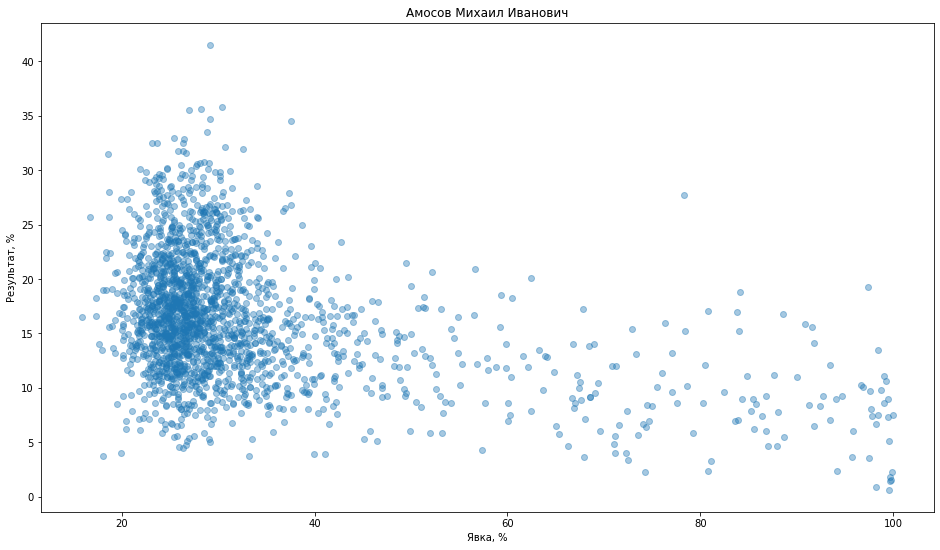

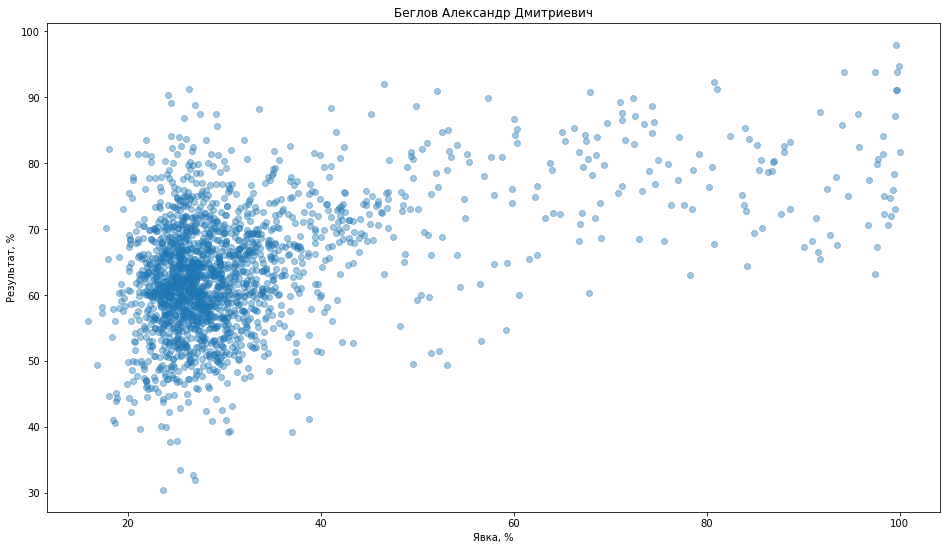

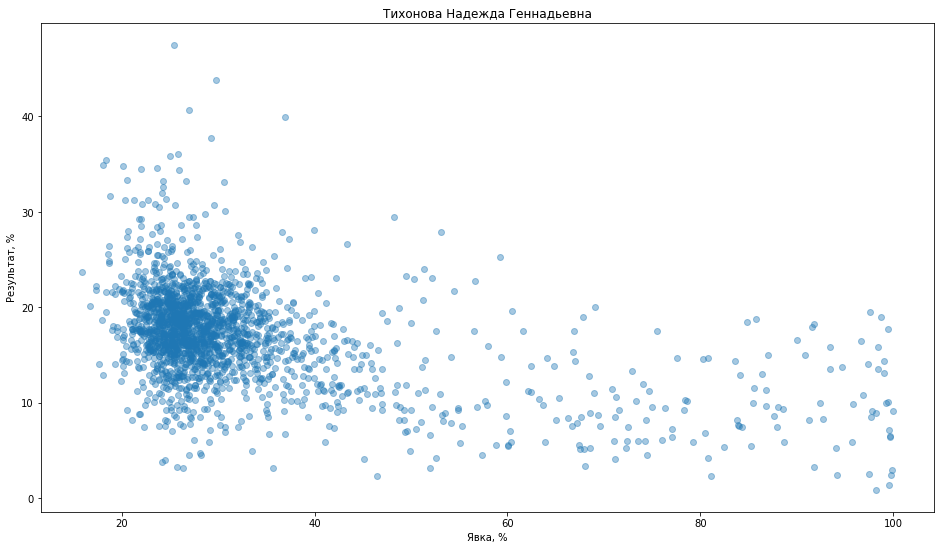

In [111]:
for candidate in candidates:
    buf = df.loc[df[f"{candidate}, %"] != 0].groupby("Явка, %")[f"{candidate}, %"].mean()

    x = buf.index
    y = buf.values


    plt.figure(figsize=(16, 9))
    plt.title(candidate)
    plt.scatter(x, y, alpha=0.4)
    plt.xlabel("Явка, %")
    plt.ylabel("Результат, %")
    plt.show()